# Medical Expense Prediction
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Loading Data](#2-loading-data)
1. [Exploratory Data Analysis](#3-exploratory-data-analysis)
1. [Data Preprocessing](#4-data-preprocessing)
    - [Dealing with Outliers](#dealing-with-outliers)
    - [Handling Categorical Features](#handling-categorical-features)
1. [Predictive Modelling](#5-predictive-modelling)
    - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [Evaluation on Test Data](#evaluation-on-test-data)
1. [Conclusion](#6-conclusion)
***


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_numeric_dtype

## 1. Introduction
Accurate forecasting of medical expenses is a critical task in the health insurance industry, directly impacting risk assessment, premium calculation, and policyholder management. With the increasing availability of structured healthcare data, machine learning has emerged as a powerful approach for modelling and predicting individual medical costs.

The primary objective of this project is to develop and evaluate machine learning models capable of predicting the medical expenses incurred by individuals, based on their personal and demographic attributes. By learning from historical data, these models aim to provide reliable cost estimates for new policyholders.

## 2. Loading Data

The dataset used in this project (retrieved from [Kaggle - Medical Insurance Cost Prediction](https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction/data)) includes:

- **Age**: Age of the policyholder
- **Sex**: Gender of the individual
- **BMI**: Body Mass Index, reflecting health status
- **Smoking** Status: Whether the individual smokes
- **Number of Children**: Count of dependents covered
- **Region**: Geographical location of residence
- **Medical** Expenses: Actual insurance charges (target variable)

In [3]:
df = pd.read_csv("_datasets/medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis

In [4]:
df.shape

(2772, 7)

In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [7]:
def plot_column_distributions(df: pd.DataFrame) -> None:
    """
    Visualise the distribution of each column in a dataframe with 7 columns.
    Numeric columns are shown as histograms with KDE, categorical as count plots.
    The figure is arranged in 2 rows and 4 columns.
    """
    n_cols = df.shape[1]
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        if is_numeric_dtype(df[col]):  # Numeric -> Histogram
            sns.histplot(
                df[col],
                kde=False if i == 3 else True,
                ax=ax,
                edgecolor="black",
            )
            ax.set_title(f"Distribution of {col}")
        else:  # Categorical -> Count plot
            sns.countplot(
                x=col,
                data=df,
                ax=ax,
                hue=col,
                palette="Set2",
                edgecolor="black",
            )
            ax.set_title(f"Count plot of {col}")

    # Remove the last subplot if there are fewer than 8 columns.
    if n_cols < len(axes):
        for j in range(n_cols, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


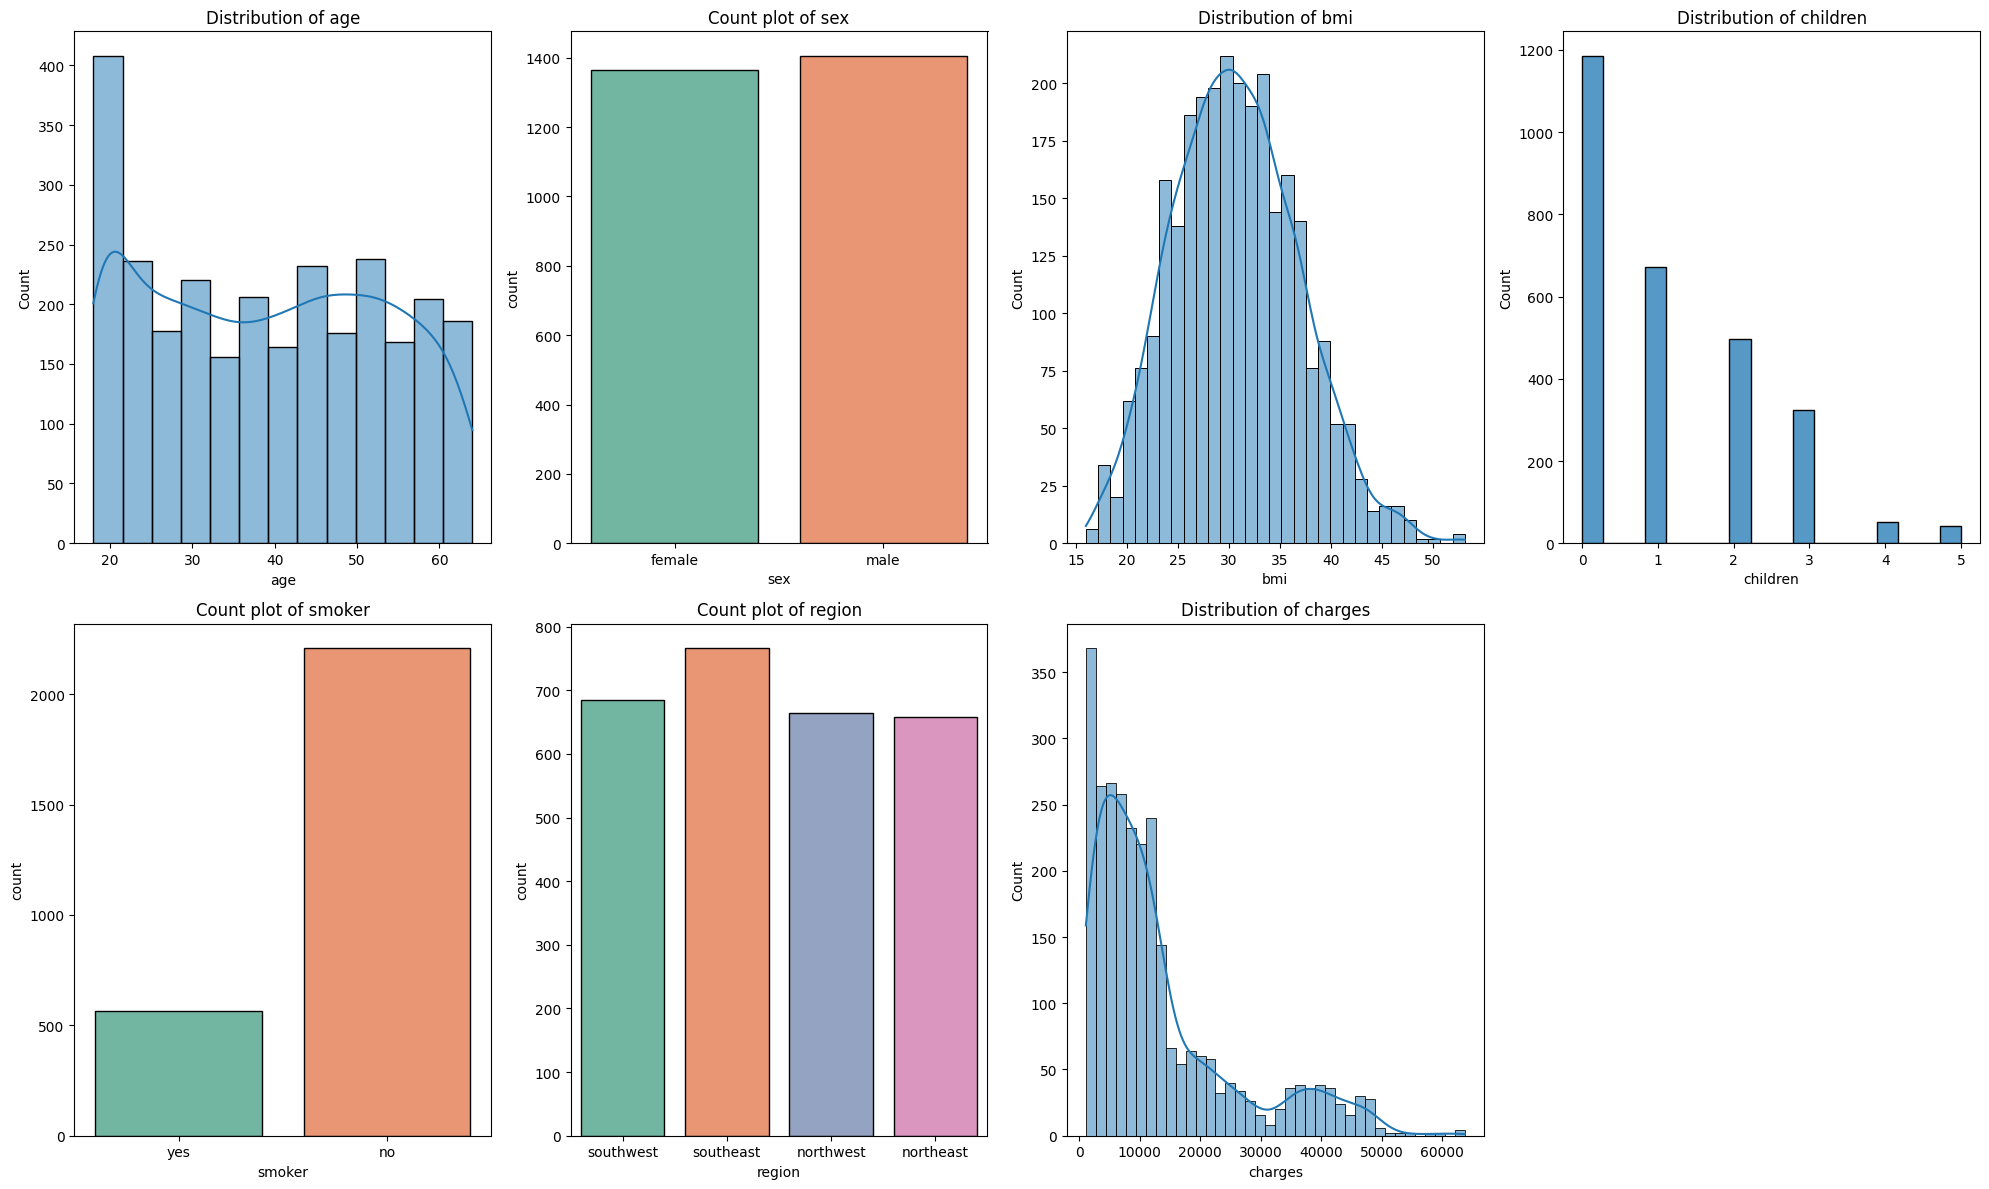

In [8]:
plot_column_distributions(df)

In [9]:
def plot_column_proportions(df: pd.DataFrame) -> None:
    cols_cat = [col for col in df.columns if not is_numeric_dtype(df[col])]
    n_pies = len(cols_cat)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i in range(n_pies):
        col = cols_cat[i]
        counts = df[col].value_counts()
        axes[i].pie(
            counts,
            labels=counts.index,
            colors=sns.color_palette("Set2", len(counts)),
            autopct="%.2f%%",
            textprops={"fontsize": 12},
        )
        axes[i].set_title(f"Proporition of {col}", fontsize=18)

    plt.tight_layout()
    plt.show()

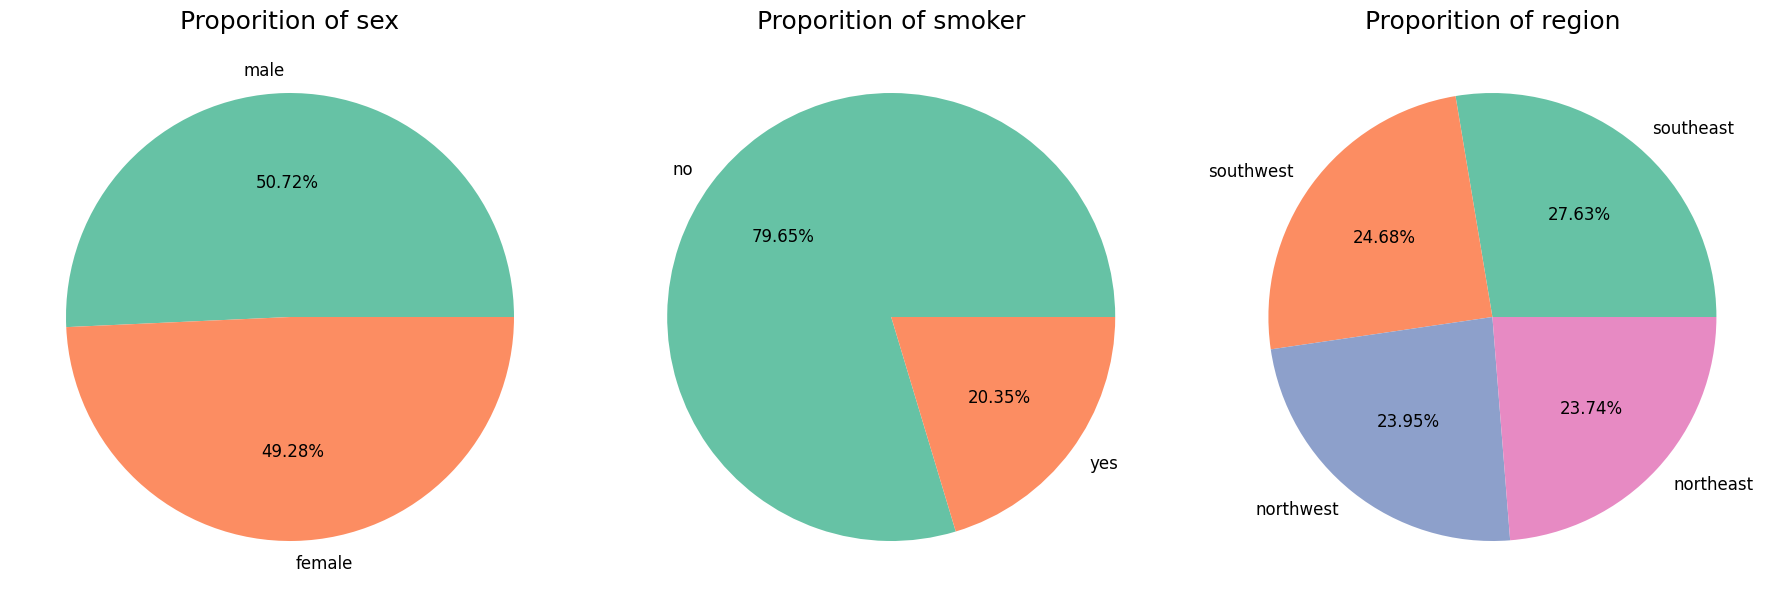

In [10]:
plot_column_proportions(df)

In [11]:
def plot_correlation_matrix(
    df: pd.DataFrame, method: str = "pearson", annot: bool = True
) -> None:
    num_columns = df.select_dtypes(include="number")

    plt.figure(figsize=(6, 5))
    corr = num_columns.corr(method=method)

    sns.heatmap(corr, annot=annot, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"{method.title()} Correlation Matrix", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks()
    plt.tight_layout()
    plt.show()

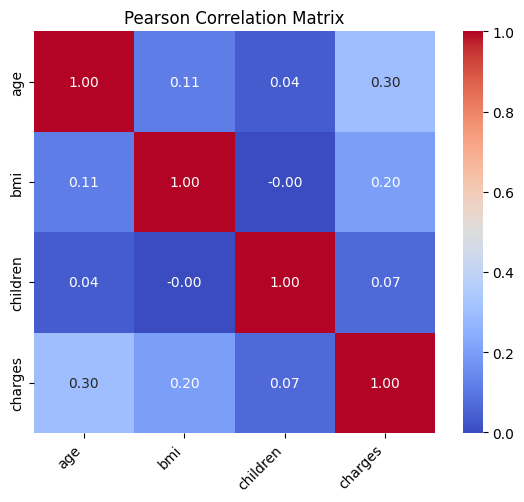

In [12]:
plot_correlation_matrix(df)

The correlation matrix reveals a slight linear relationship between charges and age, as well as between charges and BMI. However, these relationships are weak, suggesting that predicting charges using linear regression with only these variables would likely be ineffective.

## 4. Data Preprocessing

### Dealing with Outliers
- Boxplot to identify numerical outliers.
- Winsorisation or capping to handle extreme values, if necessary.

In [13]:
def plot_boxplots(df: pd.DataFrame) -> None:
    """
    Generate boxplots for each numerical column in the dataset to visualise outliers.

    Args:
        df: The input dataframe.
    """
    numerical_columns = df.select_dtypes(include=["number"]).columns

    # Create subplots for boxplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, y=column, ax=axes[i], color="skyblue")
        axes[i].set_title(f"Boxplot for {column}")
        axes[i].set_ylabel(column)
        axes[i].set_xlabel("")

    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

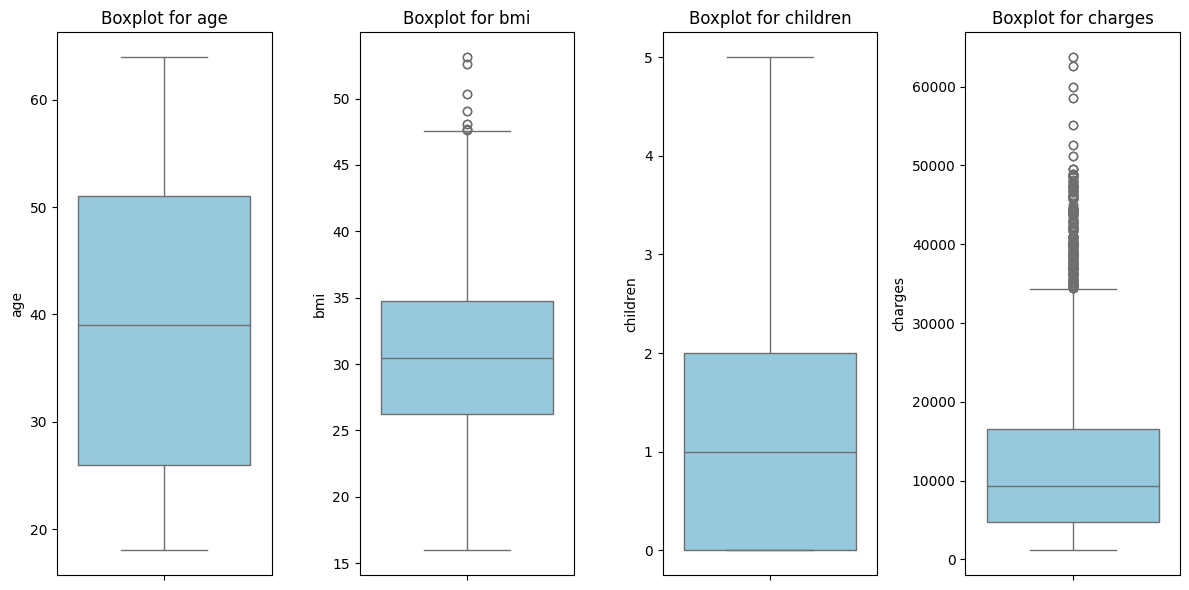

In [14]:
plot_boxplots(df)

$Q1 =$ 25th percentile

$Q3 =$ 75th percentile

$IQR =$ Interquartile Range (50% at the middle) $= Q3 - Q1$

Lower bound $= Q1 - 1.5 \times IQR$

Upper bound $= Q3 + 1.5 \times IQR$

In [15]:
def remove_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from all numerical columns in the dataframe using the IQR method.

    Args:
        df: The input dataframe.

    Returns:
        DataFrame with outliers removed from all numerical columns.
    """
    numerical_columns = df.select_dtypes(include="number")
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q1 + 1.5 * IQR  # Upper bound for outliers

        # Filter out rows with outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df


In [16]:
df = remove_outliers_iqr(df)

### Handling Categorical Features
Encoding Categorical Features:
- **sex**: Label Encoding (female = $0$, male = $1$)
- **smoker**: Label Encoding (no = $0$, yes = $1$)
- **region**: One-Hot Encoding

In [17]:
df["sex"] = df["sex"].map({"female": 0, "male": 1})
df["smoker"] = df["smoker"].map({"no": 0, "yes": 1})
df = pd.get_dummies(df, columns=["region"])

In [18]:
df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


## 5. Predictive Modelling
For this regression tasks, three regressors will be compared for evaluation:
- Linear Regression
- Random Forest Regressor
- XGBoost Regressor

In [19]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X = df.drop(columns=["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
lr = LinearRegression()
lr.fit(X_test, y_test)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Hyperparameter Tuning
Optimisation of hyperparameters is essential to obtain the best performance from both XGBoost and Random Forest models. **Grid Search** or **Random Search** is typically used to find the best hyperparameters.

The scikit-learn library provides **GridSearchCV** and **RandomizedSearchCV** functions widely used for grid and random search with cross-validation.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
rf_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 3, 5, 7, 10],
    "max_features": [None, "sqrt", "log2"],
}

rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(
    rf, rf_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")

Best parameteres for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}


In [ ]:
xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.001, 0.01, 0.1, 0.2],
}

xgb = XGBRegressor(random_state=42)
grid_search_xgb = GridSearchCV(
    xgb, xgb_param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


### Evaluation on Test Data

In [24]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R-Squared": r2}

In [25]:
best_model_rf = grid_search_rf.best_estimator_
best_model_xgb = grid_search_xgb.best_estimator_

lr_results = evaluate_model(lr, X_test, y_test)
rf_results = evaluate_model(best_model_rf, X_test, y_test)
xgb_results = evaluate_model(best_model_xgb, X_test, y_test)

In [26]:
results_df = pd.DataFrame(
    [lr_results, rf_results, xgb_results],
    index=["Linear Regression", "Random Forest", "XGBoost"],
)
print(results_df)

                            MSE         RMSE          MAE  R-Squared
Linear Regression  7.070960e+06  2659.127730  1285.430252   0.757080
Random Forest      2.424400e+06  1557.048488   616.960675   0.916711
XGBoost            2.173193e+06  1474.175215   310.805876   0.925341


In [ ]:
# Example test sample: [age, bmi, children, sex_bin, smoker_bin, region_NE, region_NW, region_SE, region_SW]
test_sample = np.array(
    [[29, 26.9, 0, 1, 0, 0, 1, 0, 0]]
)  # e.g., a 29-year-old male, non-smoker, northwest region
predicted_value = best_model_xgb.predict(test_sample)
print("Predicted value:", predicted_value[0])

Predicted value: 4152.7725


## 6. Conclusion
A comparative analysis of three different preditive models applied to the medical insurance dataset yields the following key insights:

- **XGBoost provides the best overall performance**:
    - Lowest MSE (Mean Squared Error) and RMSE (Root Mean Squared Error), reflecting the smallest average prediction errors in squared and absolute terms.
    - Lowest MAE (Mean Absolute Error), meaning its predictions are the closest to the true values on the average.
    - Highest $R^2$ (coefficient of determination) with $0.925$, explaining approximately $92.5$% of the variance in the target variable.
- **Random Forest Regressor performs well, but is outperformed by XGBoost**:
    - Slightly higher error metrics (in MSE, RMSE and MAE), and a slightly lower $R^2$ value of $0.916$.
    - Strong fit but not as accurately as XGBoost.
- **Linear Regression underperforms behind both ensemble methods**:
    - Significantly higher error metrics compared to the ensemble models.
    - $R^2$ of $0.757$ means that the model can only explain about $75$% of the variance, indicating its limitated capability to model complex, non-linear relationships present in the data.